# Correlation & (Linear) Fitting

When working with more than one variable we can use various methods to quantify how well the variables correlate with one another. We measure the correlation between two metrics using a scalar value inclusively between -1 and 1. This value is known as the *correlation coefficient*. The correlation coefficient is the covariance of a joint distribution, normalized by the product of the standard deviations of the marginal distributions.

$$
\rho_{X,Y} = \frac{\mathrm{cov}(X, Y)}{\sigma_X \sigma_Y}
$$

Values near +1 indicate a strong positive relation, values near -1 indicate a strong negative relation (inversely correlated), and values near or equal to 0 indicate weak or no relation.

## Pearson's Correlation Coefficient

Pearson's correlation coefficient (PCC) is the most commonly used correlation coefficient. It is simple to compute and provided as a function call in NumPy. There are multiple formulas for PCC. The following is used in practice.

$$
r = \frac{
        n\Sigma{xy}-(\Sigma{x})(\Sigma{y})
    }{
        [\sqrt{n\Sigma{x^{2}}-(\Sigma{x})^{2}][n\Sigma{y^{2}}-(\Sigma{y})^{2}}]
    }
$$

Here `r` is our correlation coefficient, `x` and `y` are our data, and `n` is the sample size of the data. It does not *look* too simple at first glance, but it is and is easy to compute. Consider the following dataset showing absences vs final grades for a set of students.

In [1]:
import pandas as pd

df = pd.DataFrame(
    {
        "absences": [0, 1, 1, 2, 3, 3, 4, 5, 6, 7],
        "grade": [90, 85, 88, 84, 82, 80, 75, 60, 72, 64],
    }
)
df

,absences,grade
0,0,90
1,1,85
2,1,88
3,2,84
4,3,82
5,3,80
6,4,75
7,5,60
8,6,72
9,7,64


If we visualize this, we can quickly *see* the correlation between the two metrics, but just how correlated are they? Let's visualize out data and compute the correlation coefficient using the formula above.

<Axes: xlabel='absences', ylabel='grade'>

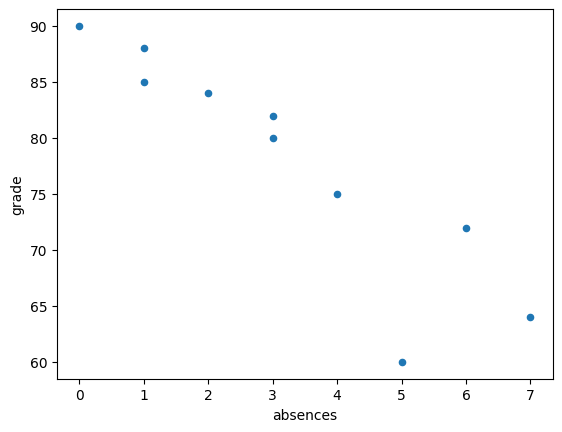

In [2]:
df.plot.scatter(x="absences", y="grade")

A quick reminder that we can reach into a data frame and grab particular columns. These columns are ultimately just `numpy` arrays, and so we can perform arithmetic operations quite easily on them! We are going create dummy variables `x`, `y`, and `n` to make write the code a bit easier.

In [3]:
n = len(df)
x = df.absences
y = df.grade
n, x, y

(10,
 0    0
 1    1
 2    1
 3    2
 4    3
 5    3
 6    4
 7    5
 8    6
 9    7
 Name: absences, dtype: int64,
 0    90
 1    85
 2    88
 3    84
 4    82
 5    80
 6    75
 7    60
 8    72
 9    64
 Name: grade, dtype: int64)

While `x` and `y` are specifically `pandas.Series` objects (and not `numpy.ndarray`), we can still utilize them as such, as they mimic the functionality provided by `numpy`. This means we can call functions like `sum` on them to compute their sum easily.

In [4]:
x.sum(), y.sum()

(32, 780)

Lastly, recall that we can apply exponents to values using the `**` operator, e.g. we can square each element of `x` using:

In [5]:
(x**2)

0     0
1     1
2     1
3     4
4     9
5     9
6    16
7    25
8    36
9    49
Name: absences, dtype: int64

In [6]:
import numpy as np

r = (n * (x * y).sum() - x.sum() * y.sum()) / np.sqrt(
    (n * (x**2).sum() - x.sum() ** 2) * ((n * (y**2).sum() - y.sum() ** 2))
)
r

-0.9061189852301499

The value of `-0.906` implies a strong negative correlation between the two variables (not necessarily causation, though in this case there is grounds to believe causation). This makes sense - as a student misses school, their grades will likely suffer.

It is instructive to implement the formula from scratch, in practice, we can compute PCC using NumPy's `corrcoef` function.

In [7]:
r = np.corrcoef(df.absences, df.grade)
r

array([[ 1.        , -0.90611899],
       [-0.90611899,  1.        ]])

The function [`numpy.corrcoef`](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html) computes the correlation coefficients, and returns to us the *correlation matrix*, which shows the correlation between each variable against every variable, including itself. Each row of this matrix represents the coefficients each variable - the first row is how well it correlates to the set; the second row is how it correlates to the set; etc.The diagonals are 1 since any variable will be strongly correlated to itself. As this can be applied to more than just 2 variables at a time, the generalized form for computing this with `numpy` is:

In [8]:
r = np.corrcoef([df.absences, df.grade])
r

array([[ 1.        , -0.90611899],
       [-0.90611899,  1.        ]])

Note the addition of the square braces. This denotes a *list* of metrics we want to compute the correlation coefficients for, and thus we are not limited to passing just two variables.

There are other means of computing correlation, but for most purposes this is sufficient. Some reminders and things to note about Pearson's Correlation:
 
* this does not indicate causation
* we cannot determine independent/dependent variables
* applicable only to linear relationships
* can be misleading in small sample sizes
* can be skewed due to clusters of data and outliers


### Visualizing Correlation Coefficient

We can use our function for visualizing joint distributions to gain some intuition about PCC. We can see how PCC is a normalized indicator of correlation or inverse correlation for linear data.

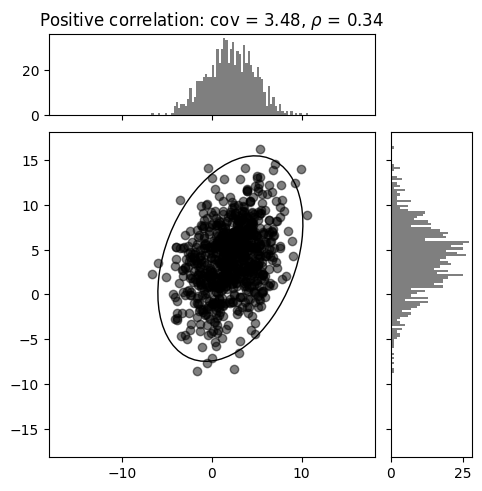

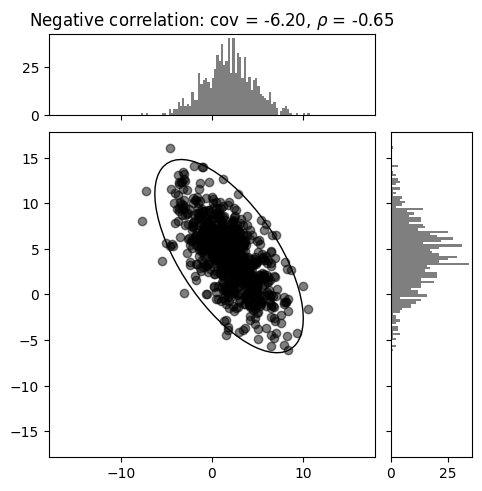

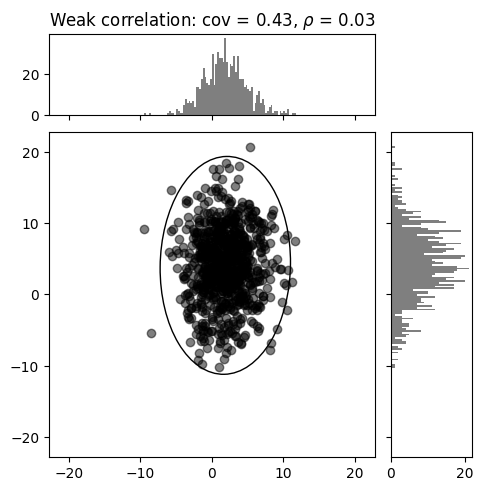

In [9]:
from joint_distribution_plotter import plot_joint_distribution


# Helper function to get a correlated dataset
def get_correlated_dataset(n, dependency, mu, scale):
    latent = np.random.randn(n, 2)
    dependent = latent.dot(dependency)
    scaled = dependent * scale
    scaled_with_offset = scaled + mu
    return scaled_with_offset[:, 0], scaled_with_offset[:, 1]


distribution_parameters = {
    "Positive correlation": [[0.85, 0.35], [0.15, -0.65]],
    "Negative correlation": [[0.9, -0.4], [0.1, -0.6]],
    "Weak correlation": [[1, 0], [0, 1]],
}

mu = 2, 4
scale = 3, 5

for title, dependency in distribution_parameters.items():

    # Get example data with the given dependency matrix
    x, y = get_correlated_dataset(800, dependency, mu, scale)

    cov_matrix = np.cov(x, y)
    r_pcc = np.corrcoef(x, y)
    title = (
        title + f": cov = {cov_matrix[0,1]:.2f}, $\\rho$ = {r_pcc[0,1]:.2f}"
    )

    # Plot the data
    plot_joint_distribution(x, y, title)

## Linear Fitting

Another way we can assess correlation, and as discussed in reference to *Anscombe's Quartet*, is to produce and visualize linear trend lines overtop a scatter of the data. As we have briefly seen before, `numpy` also makes this easy. We are going to make use of `numpy`'s *Polynomial API*.

`numpy` implements a very powerful and flexible [Polynomial API](https://numpy.org/doc/stable/reference/routines.polynomials.html) with many polynomial finding routines implemented. Using a spread of data points we can determine approximate polynomial fittings. For our purposes for looking at correlation, we really only need to use a least squares fit.

We can start by using the `polyfit` function to determine the coefficients of our fitting polynomial:

In [10]:
import numpy.polynomial.polynomial as polynomial

coefficients = polynomial.polyfit(df.absences, df.grade, 1)
coefficients

array([90.70588235, -3.97058824])

These coefficients are for a polynomial of the form:

$$
p(x) = c_{0} + c_{1}x + c_{2}x^{2} + ...
$$

With these coefficients, we can then use the `polyval` function to evaluate the polynomial with these coefficients at the bounds of out data:

In [11]:
fit = polynomial.polyval([0, 7], coefficients)
fit

array([90.70588235, 62.91176471])

Text(4, 85, 'f(x) $\\approx$ 90.71 - 3.97 x')

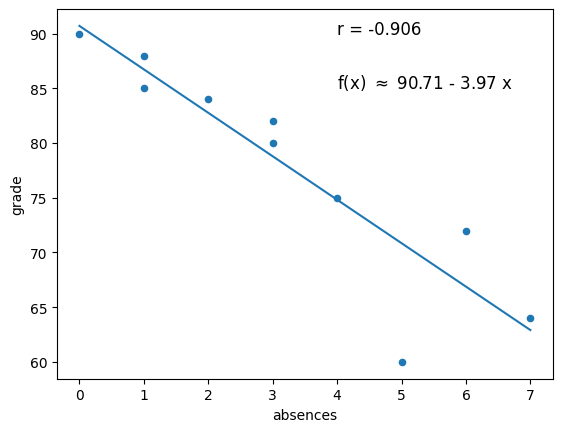

In [12]:
ax = df.plot.scatter("absences", "grade")
ax.plot([0, 7], fit)
ax.text(x=4, y=90, s=f"r = {r[0][1]:.3f}", fontsize="large")

# create a nicely formatted polynomial
poly = polynomial.Polynomial([_.round(2) for _ in coefficients])

ax.text(x=4, y=85, s=f"f(x) $\\approx$ {poly}", fontsize="large")

This matches our expectations as we can see a clear trend in the data reinforced with our linear fit.

### Where Linear Correlation Does Not Work

As mentioned, there are times when computing the correlation for a data set does not make sense. We are going to take a quick look at some examples of when we want to avoid looking at correlation and linear trends.

#### Nonlinear Data

As correlation is a linear statistic, it is not applicable to use for non-linear data. This does not mean the variables being assessed are not correlated or related in some way, just that we cannot quantify that relationship with the methods learned. Consider quadratic data and its trend line:

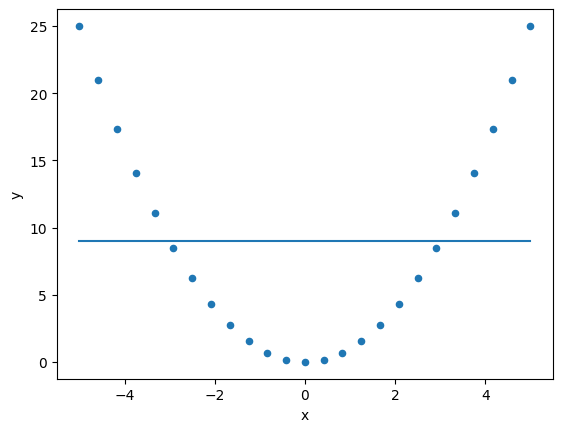

In [13]:
quadratic = pd.DataFrame({"x": np.linspace(-5, 5, 25)})
quadratic["y"] = quadratic.x**2
ax = quadratic.plot.scatter("x", "y")

coefficients = polynomial.polyfit(quadratic.x, quadratic.y, 1)
fit = polynomial.polyval([-5, 5], coefficients)
ax.plot([-5, 5], fit)

The trend line asserts that there is no variability within the data (slope == 0). Now let's compute Pearson's Correlation Coefficient:

In [14]:
r = np.corrcoef(quadratic.x, quadratic.y)
r

array([[1.000000e+00, 1.291734e-16],
       [1.291734e-16, 1.000000e+00]])

Here we have a coefficient that is essentially 0, though there very well could be a relationship at work here (one that just is not linear!)

#### Small Sample Sizes

This one is applicable to more than just linear correlation - any sample size that is too small is hard to use to draw meaningful conclusions. Consider the following contrived dataset:

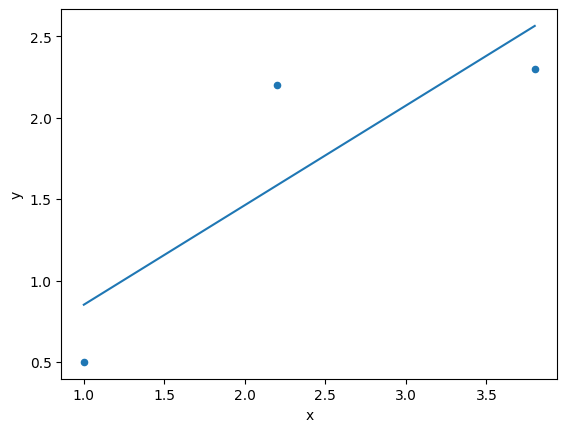

In [15]:
small = pd.DataFrame({"x": [1.0, 2.2, 3.8], "y": [0.5, 2.2, 2.3]})
ax = small.plot.scatter("x", "y")

coefficients = polynomial.polyfit(small.x, small.y, 1)
fit = polynomial.polyval([1.0, 3.8], coefficients)
ax.plot([1.0, 3.8], fit)

Now let's compute Pearson's Correlation Coefficient:

In [16]:
r = np.corrcoef(small.x, small.y)
r

array([[1.        , 0.84913849],
       [0.84913849, 1.        ]])

With our limited data we are told that there is a strong correlation between our variables, but 3 data points is hardly enough to really understand the data. A single additional data point that is within the range of our current data could greatly swing our correlation coefficient in either direction.

#### Clusters of Data

Our data may consist of various clusters of points - these clusters themselves may or may not have trends within, but collectively may show a trend altogether that may be misleading:

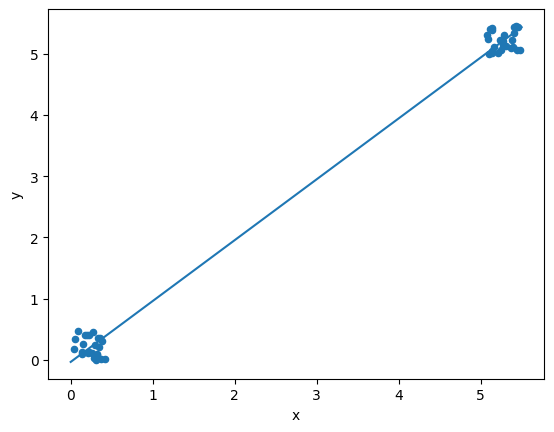

In [17]:
clusters = pd.DataFrame(
    {
        "x": np.concatenate(
            [np.random.uniform(0.0, 0.5, 25), np.random.uniform(5.0, 5.5, 25)]
        ),
        "y": np.concatenate(
            [np.random.uniform(0.0, 0.5, 25), np.random.uniform(5.0, 5.5, 25)]
        ),
    }
)
ax = clusters.plot.scatter("x", "y")

coefficients = polynomial.polyfit(clusters.x, clusters.y, 1)
fit = polynomial.polyval([0.0, 5.5], coefficients)
ax.plot([0.0, 5.5], fit)

In [18]:
r = np.corrcoef(clusters.x, clusters.y)
r

array([[1.        , 0.99686459],
       [0.99686459, 1.        ]])

There appears to be a very string correlation here in our data, but it is likely more useful to evaluate the individual clusters. 

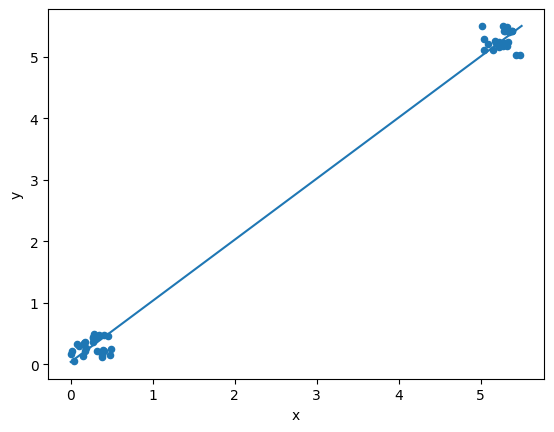

In [19]:
clusters = pd.DataFrame(
    {
        "x": np.concatenate(
            [np.random.uniform(0.0, 0.5, 25), np.random.uniform(5.0, 5.5, 25)]
        ),
        "y": np.concatenate(
            [np.random.uniform(0.0, 0.5, 25), np.random.uniform(5.0, 5.5, 25)]
        ),
    }
)
ax = clusters.plot.scatter("x", "y")

coefficients = polynomial.polyfit(clusters.x, clusters.y, 1)
fit = polynomial.polyval([0.0, 5.5], coefficients)
ax.plot([0.0, 5.5], fit)

In [20]:
r = np.corrcoef(clusters.x, clusters.y)
r

array([[1.        , 0.99743854],
       [0.99743854, 1.        ]])

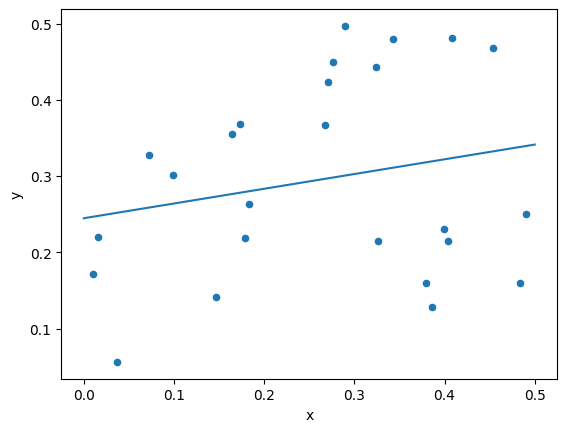

In [21]:
cluster1 = clusters.iloc[:25]
ax = cluster1.plot.scatter("x", "y")

coefficients = polynomial.polyfit(cluster1.x, cluster1.y, 1)
fit = polynomial.polyval([0.0, 0.5], coefficients)
ax.plot([0.0, 0.5], fit)

In [22]:
r = np.corrcoef(cluster1.x, cluster1.y)
r

array([[1.        , 0.21877918],
       [0.21877918, 1.        ]])

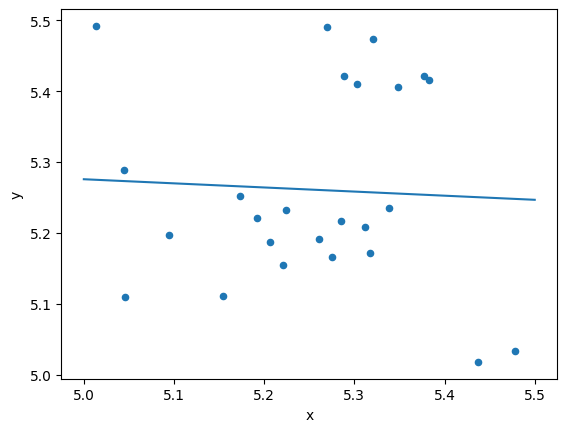

In [23]:
cluster2 = clusters.iloc[25:]
ax = cluster2.plot.scatter("x", "y")

coefficients = polynomial.polyfit(cluster2.x, cluster2.y, 1)
fit = polynomial.polyval([5.0, 5.5], coefficients)
ax.plot([5.0, 5.5], fit)

In [24]:
r = np.corrcoef(cluster2.x, cluster2.y)
r

array([[ 1.        , -0.04925435],
       [-0.04925435,  1.        ]])

#### Outliers

Outliers in data can greatly skew measures of correlation within a data set.

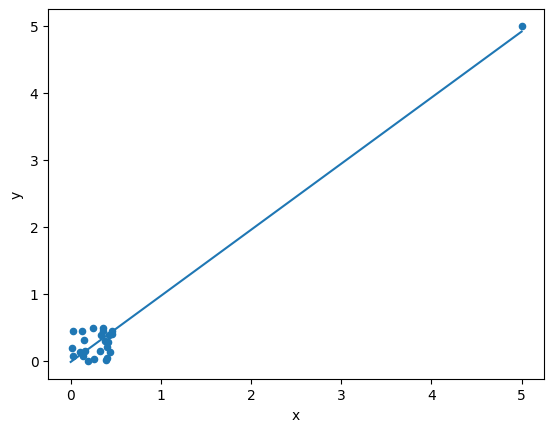

In [25]:
outlier = pd.DataFrame(
    {
        "x": np.random.uniform(0.0, 0.5, 25),
        "y": np.random.uniform(0.0, 0.5, 25),
    }
)
outlier.iloc[-1] = [5.0, 5.0]
ax = outlier.plot.scatter("x", "y")

coefficients = polynomial.polyfit(outlier.x, outlier.y, 1)
fit = polynomial.polyval([0.0, 5.0], coefficients)
ax.plot([0.0, 5.0], fit)

In [26]:
r = np.corrcoef(outlier.x, outlier.y)
r

array([[1.        , 0.97828582],
       [0.97828582, 1.        ]])

Again our trend line and correlation coefficient indicate a strong relation in the data, but the single outlier at `(5.0, 5.0)` is skewing our assessment of the data. If we strip that value from our data, we see that there is not much to our data.

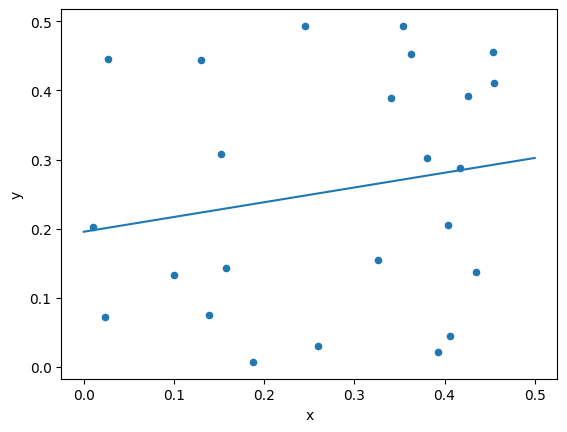

In [27]:
outlier_removed = outlier.iloc[:-1]
ax = outlier_removed.plot.scatter("x", "y")

coefficients = polynomial.polyfit(outlier_removed.x, outlier_removed.y, 1)
fit = polynomial.polyval([0.0, 0.5], coefficients)
ax.plot([0.0, 0.5], fit)

In [28]:
r = np.corrcoef(outlier_removed.x, outlier_removed.y)
r

array([[1.        , 0.18789449],
       [0.18789449, 1.        ]])

This is a much more accurate representation of our data! However, it is worth noting that outliers in data are not necessarily bad. There very well could be something in your model or system that behaves outlandish under certain criteria, and while it may make some statistical operations and observations worse/less conclusive, it is always best to understand the reasons behind any and all outliers!

## Mutual Information

We saw above how correlation fails to capture nonlinear dependencies in data. In practice, two series may be closely related but uncorrelated. Mutual information can be a useful metric in these cases.

Mutual information is defined for discrete random variables

$$
\mathrm{I}(X;Y) = \sum_{y \in \mathcal{Y}} \sum_{x \in \mathcal{X}} P_{(X,Y)}(x,y) \mathrm{log}\left(\frac{P_{(X,Y)}(x,y)}{P_X(x)P_Y(y)}\right),
$$

and for continuous random variables

$$
\mathrm{I}(X;Y) = \int_{\mathcal{Y}} \int_{\mathcal{X}} P_{(X,Y)}(x,y) \mathrm{log}\left(\frac{P_{(X,Y)}(x,y)}{P_X(x)P_Y(y)}\right) dx dy.
$$

The challenge to applying MI in practice is that both of these expressions require knowledge of the joint and marginal distributions, which is often not known. This can be estimated from histograms, but this is inefficient.

MI is often more readily applied to tabular features which lend to more tractable estimation of the joint and marginal distributions. For non-tabular features (e.g., images and videos) application of MI is a subject of a significant amount of modern research in information theoretic learning.

Here we explore using mutual information to inspect the Titanic passenger dataset and then revisit the problem of detecting a dependency which may be nonlinear.

As we will see, mutual information is an incredibly useful tool for determining which features in a tabular dataset are important to visualize. Unlink principal component analysis, which creates a few new features that capture the important information in many old features, mutual information detects the subset of features which are most related to a given pattern.

As an optional exercise, write a quick block of code which loops through the titanic dataset and tests which features (columns) have the highest mutual information with the passenger survival rates.


In [29]:
import pandas as pd
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import (
    mutual_info_classif,
    mutual_info_regression,
)

data = pd.read_csv(
    "./_resources/train.csv",
    na_values="?",
    dtype={"fare": float, "age": float},
)

data.dropna(subset=["Embarked", "Fare"], inplace=True)
data["Age"] = data["Age"].fillna(data["Age"].mean())

data.loc[data["Sex"] == "male", "Sex"] = 0
data.loc[data["Sex"] == "female", "Sex"] = 1

print("Cleaned up dataframe:")
print(data.head())

print("\nMI between discrete variables, sex and ticket class:")
print(mutual_info_score(data["Sex"], data["Pclass"]))

print("\nMI between continuous and discrete variables, fare and survival:")
print(
    mutual_info_classif(
        data["Fare"].to_frame(), data["Survived"], discrete_features=[False]
    )
)

print("\nMI between continuous and discrete variables, fare and ticket class:")
print(
    mutual_info_classif(
        data["Fare"].to_frame(), data["Pclass"], discrete_features=[False]
    )
)

print("\nMI between continuous variables, fare and age:")
print(
    mutual_info_regression(
        data["Fare"].to_frame(), data["Age"], discrete_features=[False]
    )
)

Cleaned up dataframe:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris   0  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...   1  38.0      1      0   
2                             Heikkinen, Miss. Laina   1  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)   1  35.0      1      0   
4                           Allen, Mr. William Henry   0  35.0      0      0   

             Ticket     Fare Cabin Embarked  
0         A/5 21171   7.2500   NaN        S  
1          PC 17599  71.2833   C85        C  
2  STON/O2. 3101282   7.9250   NaN        S  
3            113803  53.1000  C123        S  
4            373450   8.0500   NaN        S  

MI 

Here we revisit the problem we saw earlier with determining whether or not two nonlinearly related variables are actually related.

R (quadratic) = 0.000

R (random) = -0.004

MI (quadratic) = 0.647

MI (random) = 0.002


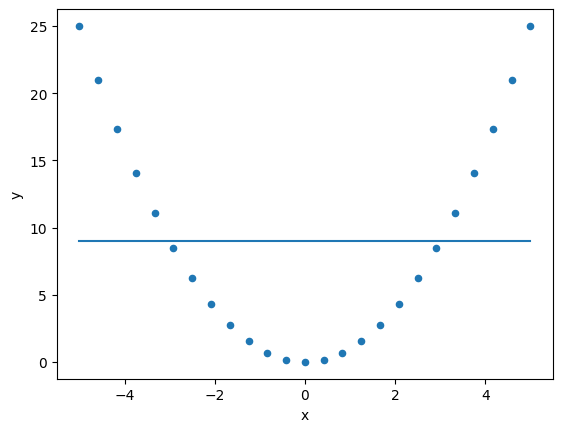

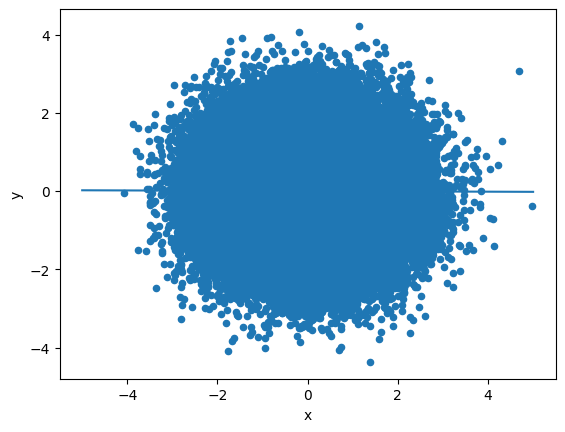

In [30]:
# Generate Quadratic Data
quadratic = pd.DataFrame({"x": np.linspace(-5, 5, 25)})
quadratic["y"] = quadratic.x**2
ax = quadratic.plot.scatter("x", "y")

coefficients = polynomial.polyfit(quadratic.x, quadratic.y, 1)
fit = polynomial.polyval([-5, 5], coefficients)
ax.plot([-5, 5], fit)

# Generate Random Data
random_data = pd.DataFrame(
    {
        "x": np.random.randn(100000),
        "y": np.random.randn(100000),
    }
)

coefficients = polynomial.polyfit(random_data.x, random_data.y, 1)
ax = random_data.plot.scatter("x", "y")
fit = polynomial.polyval([-5, 5], coefficients)
ax.plot([-5, 5], fit)


r_quadratic = np.corrcoef(quadratic.x, quadratic.y)
print(f"R (quadratic) = {r_quadratic[0,1]:.3f}")


r_random = np.corrcoef(random_data.x, random_data.y)
print(f"\nR (random) = {r_random[0,1]:.3f}")

mi_quadratic = mutual_info_regression(
    quadratic.x.to_frame(), quadratic.y, discrete_features=[False]
)
print(f"\nMI (quadratic) = {mi_quadratic[0]:.3f}")


mi_random = mutual_info_regression(
    random_data.x.to_frame(), random_data.y, discrete_features=[False]
)
print(f"\nMI (random) = {mi_random[0]:.3f}")